## Tretja domača naloga
Opravljanje domačih nalog je **obvezno**. Uspešno rešene domače naloge so **pogoj za pristop k izpitu**. Rok za oddajo je **torek, 8. november ob 23:59**.

Domače naloge rešujte **samostojno**.

## Gradivo
Pri reševanju domače naloge uporabite množico podatkov **Complete Blood Count**, ki vključuje 420 slik brisov krvi, zajetih pod mikroskopom ter njihove označbe. Podatki so na voljo v skupni mapi, ki jih najdete na poti `/home/<username>/shared/Complete-Blood-Cell-Count-Dataset`, kjer namesto `<username>` vstavite svoje uporabniško ime. Pot do podatkov je za vas **že definirana** v spremenljivki `DATA_PATH`.

### Delitev podatkovne množice

Podatkovna množica je razdeljena na **učno** (*Training*), **validacijsko** (*Validation*) in **testno** (*Testing*) podmnožico, ki vsebujejo 360, 60 in 60 primerov.

Vse tri podmnožice vsebujejo podmapo slik (*Images*) ter podmabo označb (*Annotations*).

```
Complete-Blood-Cell-Count-Dataset
                              |__Training
                              |         |__ Images
                              |         |__ Annotations
                              |
                              |__Validation
                              |         |__ Images
                              |         |__ Annotations
                              |
                              |__ Testing
                                        |__ Images
                                        |__ Annotations
                              
```

V podmapi slik so pod imeni `BloodImage_<id>.jpg` na voljo slike brisov, v podmapi anotacij pa njihove pripadajoče označbe `BloodImage_<id>.xml`. V vsaki XML datoteki element `<object>` označuje krvno celico in njene opisne atribute.

*Primer:*

```
<annotation>
	<folder>JPEGImages</folder>
	<filename>BloodImage_00339.jpg</filename>
	<path>/home/pi/detection_dataset/JPEGImages/BloodImage_00339.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>640</width>
		<height>480</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>    
	<object>
		<name>RBC</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>378</xmin>
			<ymin>278</ymin>
			<xmax>489</xmax>
			<ymax>374</ymax>
		</bndbox>
	</object>
    
    ...
    
</annotation>
```

Anotacije vsebujejo tri tipe celic (*object*), ki se pojavljajo na sliki. Njihovo ime je shranjeno v atributu `<name>`, in sicer:
- **RBC**: eritrocit,
- **WBC**: levkocit,
- **Platelets**: trombocit.

## Opis problema

Na zbirki slik boste naučili model nevronske mreže, tokrat za nalogo **regresije**. Načrtali in naučili boste model za avtomatsko štetje eritrocitov iz slike krvnih celic. Torej, za vhodno spremenljivko $X$ (slika) in izhod $y$ (število eritricitov),se bo model naučil funkcijo preslikave $f$, $$y=f(X).$$

In [ ]:
from __future__ import print_function

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as itk
import tensorflow as tf

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,BatchNormalization
from keras import backend as K
from keras.callbacks import Callback
import amslib
from os.path import exists, join

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# Fiksiramo psevdonakljucni generator stevil
seed = 42
random.seed = seed
np.random.seed = seed

# POT DO PODATKOV
user = os.getenv('JUPYTERHUB_USER')
DATA_PATH = join('/home', user, 'shared/Complete-Blood-Cell-Count-Dataset')

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

### Prikazovanje podatkov in anotacij
Pred učenjem nevronskih mrež preglejte svoje podatke.
* Naložite poljubno sliko in jo prikažite.
* S pomočjo funkcije `parseElementAttributes` v datoteki `amslib.py` preberite pripadajočo XML datoteko in izpišite njen rezultat. Funkcija kot vhod sprejme spremenljivke:
        - `xml_path`: pot do XML datoteke,
        - `element_name`: ime elementa, ki ga iščemo,
        - `attr_name`: atribut elementa, ki nas zanima,
 kot izhod pa vrne seznam tekstovnih vnosov iskanih atributov.
* Kakšno je število eritrocitov, levkocitov in trombocitov v vaši sliki?

['WBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC']


(480, 640, 3)

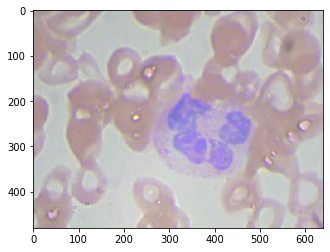

In [ ]:
### BEGIN SOLUTION


### END SOLUTION

### Nalaganje podatkov

Za branje učne, validacijske in testne množice uporabite funkcijo `load_blood_data` v knjižnici `amslib.py`, ki kot vhod sprejme pot do podatkov. Funkcija prebere slike, jih podvorči ter prebere njihove pripadajoče XML datoteke.
* Uvozite funkcijo in naložite podatke.
* Izpišite velikost vseh treh podatkovnih podmnožic. Velikost slike primerjajte z originalno sliko. Za kakšen faktor smo zmanjšali osnovno sliko?
* Kakšno je povprečno število eritrocitov na vsaki izmed treh množic?

In [ ]:
X_tr, X_val, X_ts, y_tr, y_val, y_ts = load_blood_data()

### BEGIN SOLUTION

### END SOLUTION


(300, 60, 80, 3)
Ucna: 11.136666666666667, Validacijska: 11.666666666666666, Testna: 13.2
Velikosti podatkovnih množic:
(300, 60, 80, 3) (60, 60, 80, 3) (60, 60, 80, 3)
(300,) (60,) (60,)

Število slik za trening: 300
Število slik za validacijo: 60
Število slik za testiranje: 60

Originalna slika je velikosti: 480 x 640 pixlov.
Zmanjšana slika je velikosti: 60 x 80 pixlov.
Sliko smo zmanjšali za faktor: 8.0

Povprečno število eritrocitov v množici za treniranje: 11.1
Povprečno število eritrocitov v množici za validacijo: 11.7
Povprečno število eritrocitov v množici za testiranje: 13.2


### Definicija in učenje modelov
Načrtajte arhitekturo konvolucijske nevronske mreže in naučite model za avtomatsko štetje števila eritrocitov iz slike.

Kot osnovo uporabite arhitekturo, ki smo jo uporabili na vajah za primer razvrščanja (`2_Razvscanje_slik`). Ustrezno popravite zadnji `Dense` nivo, torej izhodni nivo, da bo število izhodnih nevronov zadoščalo dani nalogi **regresije**. Določite tudi ustrezno aktivacijsko funkcijo.

| Nivo (tip)       	| parametri  	| vhodno št. kanalov 	| izhodno št. kanalov 	|
|------------------	|------------	|--------------------	|---------------------	|
| Konvolucijski 2D 	| dim(K)=3x3 	| 3                  	| 32                  	|
| Konvolucijski 2D 	| dim(K)=3x3 	| 32                 	| 64                  	|
| Združevanje      	| dim(K)=2x2 	|                    	|                     	|
| Izpust           	| rate=0.75  	|                    	|                     	|
| Polno povezan    	| act=ReLU   	| **                 	| 128                 	|
| Izpust           	| rate=0.5   	|                    	|                     	|
| Polno povezan    	| **ustrezno določite**  | 128        	| **ustrezno določite** |

* Načrtajte arhitekturo zgornjega modela in jo po potrebi izboljšajte.
* Naučite modela za nalogo napovedi števila eritrocitov na sliki. Za učenje modelov uporabite učno množico, za validacijo pa validacijsko množico. Določite ustrezne vrednosti **hipermarametrov** ter ustrezno [funkcijo izgube](https://keras.io/api/losses/). Kot metriki modela tekom učenja izpišite srednjo absolutno napako (*angl. Mean Absolute Error*) ter srednjo kvadratično napako (*angl. Mean Squared Error*) na učni in validacijski množici.
* Izpišite končno vrednost funkcije izgube.

In [ ]:
model1 = Sequential()
### BEGIN SOLUTION


### END SOLUTION

Train on 300 samples, validate on 60 samples
Epoch 1/150
300/300 [==============================] - 1s 2ms/step - loss: 31.9574 - mean_squared_error: 31.9574 - mean_absolute_error: 4.2835 - val_loss: 26.9413 - val_mean_squared_error: 26.9413 - val_mean_absolute_error: 4.0736
Epoch 2/150
300/300 [==============================] - 0s 457us/step - loss: 24.2653 - mean_squared_error: 24.2653 - mean_absolute_error: 3.7850 - val_loss: 29.1442 - val_mean_squared_error: 29.1442 - val_mean_absolute_error: 4.2950
Epoch 3/150
300/300 [==============================] - 0s 490us/step - loss: 23.5267 - mean_squared_error: 23.5267 - mean_absolute_error: 3.7724 - val_loss: 27.6209 - val_mean_squared_error: 27.6209 - val_mean_absolute_error: 4.1382
Epoch 4/150
300/300 [==============================] - 0s 469us/step - loss: 22.8881 - mean_squared_error: 22.8881 - mean_absolute_error: 3.6081 - val_loss: 29.6778 - val_mean_squared_error: 29.6778 - val_mean_absolute_error: 4.3493
Epoch 5/150
300/300 [====

Epoch 36/150
300/300 [==============================] - 0s 441us/step - loss: 21.3546 - mean_squared_error: 21.3546 - mean_absolute_error: 3.5416 - val_loss: 15.2677 - val_mean_squared_error: 15.2677 - val_mean_absolute_error: 3.0242
Epoch 37/150
300/300 [==============================] - 0s 451us/step - loss: 19.7793 - mean_squared_error: 19.7793 - mean_absolute_error: 3.4517 - val_loss: 18.7788 - val_mean_squared_error: 18.7788 - val_mean_absolute_error: 3.3736
Epoch 38/150
300/300 [==============================] - 0s 444us/step - loss: 18.4272 - mean_squared_error: 18.4272 - mean_absolute_error: 3.4023 - val_loss: 14.7432 - val_mean_squared_error: 14.7432 - val_mean_absolute_error: 2.9783
Epoch 39/150
300/300 [==============================] - 0s 450us/step - loss: 18.3105 - mean_squared_error: 18.3105 - mean_absolute_error: 3.3371 - val_loss: 14.3034 - val_mean_squared_error: 14.3034 - val_mean_absolute_error: 2.9858
Epoch 40/150
300/300 [==============================] - 0s 457us

300/300 [==============================] - 0s 435us/step - loss: 14.2201 - mean_squared_error: 14.2201 - mean_absolute_error: 2.9427 - val_loss: 7.6341 - val_mean_squared_error: 7.6341 - val_mean_absolute_error: 2.0919
Epoch 72/150
300/300 [==============================] - 0s 445us/step - loss: 12.9133 - mean_squared_error: 12.9133 - mean_absolute_error: 2.8310 - val_loss: 7.0419 - val_mean_squared_error: 7.0419 - val_mean_absolute_error: 2.0202
Epoch 73/150
300/300 [==============================] - 0s 447us/step - loss: 11.3528 - mean_squared_error: 11.3528 - mean_absolute_error: 2.7051 - val_loss: 7.7063 - val_mean_squared_error: 7.7063 - val_mean_absolute_error: 2.0927
Epoch 74/150
300/300 [==============================] - 0s 439us/step - loss: 11.4320 - mean_squared_error: 11.4320 - mean_absolute_error: 2.6226 - val_loss: 9.5458 - val_mean_squared_error: 9.5458 - val_mean_absolute_error: 2.4117
Epoch 75/150
300/300 [==============================] - 0s 463us/step - loss: 10.8745

300/300 [==============================] - 0s 436us/step - loss: 8.0644 - mean_squared_error: 8.0644 - mean_absolute_error: 2.3325 - val_loss: 7.8403 - val_mean_squared_error: 7.8403 - val_mean_absolute_error: 2.4813
Epoch 107/150
300/300 [==============================] - 0s 446us/step - loss: 9.0389 - mean_squared_error: 9.0389 - mean_absolute_error: 2.2806 - val_loss: 3.3585 - val_mean_squared_error: 3.3585 - val_mean_absolute_error: 1.4123
Epoch 108/150
300/300 [==============================] - 0s 443us/step - loss: 9.1008 - mean_squared_error: 9.1008 - mean_absolute_error: 2.4271 - val_loss: 2.4747 - val_mean_squared_error: 2.4747 - val_mean_absolute_error: 1.1561
Epoch 109/150
300/300 [==============================] - 0s 445us/step - loss: 8.0656 - mean_squared_error: 8.0656 - mean_absolute_error: 2.3025 - val_loss: 3.1432 - val_mean_squared_error: 3.1432 - val_mean_absolute_error: 1.3359
Epoch 110/150
300/300 [==============================] - 0s 433us/step - loss: 10.4214 - m

300/300 [==============================] - 0s 467us/step - loss: 7.1727 - mean_squared_error: 7.1727 - mean_absolute_error: 2.1126 - val_loss: 2.5215 - val_mean_squared_error: 2.5215 - val_mean_absolute_error: 1.2798
Epoch 142/150
300/300 [==============================] - 0s 441us/step - loss: 8.0666 - mean_squared_error: 8.0666 - mean_absolute_error: 2.2542 - val_loss: 1.6198 - val_mean_squared_error: 1.6198 - val_mean_absolute_error: 1.0014
Epoch 143/150
300/300 [==============================] - 0s 442us/step - loss: 7.4481 - mean_squared_error: 7.4481 - mean_absolute_error: 2.1402 - val_loss: 2.7727 - val_mean_squared_error: 2.7727 - val_mean_absolute_error: 1.3799
Epoch 144/150
300/300 [==============================] - 0s 464us/step - loss: 7.3433 - mean_squared_error: 7.3433 - mean_absolute_error: 2.1672 - val_loss: 3.7499 - val_mean_squared_error: 3.7499 - val_mean_absolute_error: 1.6845
Epoch 145/150
300/300 [==============================] - 0s 438us/step - loss: 7.1879 - me

Komentirajte rezultate učenja in vaše izkušnje s prilagajanjem arhitekture in hiperparametrov. Kakšne so vrednosti metrik naučenega modela? Kakšne so vrednosti hiperparametrov?

**ODGOVOR:**

### Primerjava vrednosti kriterijskih funkcij
Napovejte število eritrocitov na testni podmnožici in ovrednotite uspešnost modela.

* Izpišite in primerjajte vrednosti srednje kvadratične napake in srednje absolutne napake na učni, validacijski in testni množici.
* Kakšna je razlika med učno in testno napako modela?

In [ ]:
# Mean Absolute Error
# Mean Squared Error
### BEGIN SOLUTION

### END SOLUTION

[1.6020450814565024, 1.6020450814565024, 5.981333465576172]
Učna zbirka
	MSE: 1.6020450814565024
	MAE: 5.981333465576172
Validacijska zbirka
	MSE: 1.9109301249186197
	MAE: 8.664375940958658
Testna zbirka
	MSE: 3.147157335281372
	MAE: 15.74065736134847


### Vizualizacija napovedi modela
Vizualno prikažite napovedi posameznega modela na učni, validacijski in testni množici (3 grafi).
* Za vsako podmnožico narišite graf, ki ima na $x$ osi dejanske vrednosti števila eritrocitov ($y_i$), na $y$ osi pa napovedne vrednosti ($y'_i$).  Na grafe izrišite še linearno premico $y=x$, ki naj služi kot pomoč pri vizualni oceni rezultatov.
* Kaj predstavlja linearna premica $y=x$?  

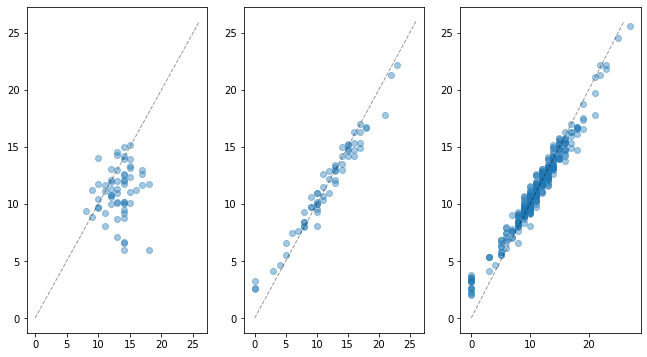

[11.177959  12.074429  12.122704  12.388653  12.660227   8.749823
  6.691202  13.032654   5.9953156  9.99861   12.025511  11.786453
 10.061342  11.624939   7.129878   9.226955   9.700317  12.54808
 10.1692295 14.951221   9.60331   11.745598   9.972919  14.038361
  8.052973  13.919237   8.686079  11.77137   14.302759  11.256163
  5.9818234  9.488867  13.321064  15.176699  12.98958   11.919168
 10.17244   10.788643  13.147156  11.983456  13.909304  10.451269
 10.930393   8.851091  10.039347  12.653393   9.40192   11.016102
 11.352531   9.172632  11.686884  11.174374  14.544331  10.76634
 14.233084  11.268551  10.203142   6.5331445 10.65008   13.009232 ]
[ 6.9995713  9.590956  12.772053  10.853796  13.511995   3.791644
 10.167692  10.351566   7.453114  11.183332  11.12619    8.010046
 12.055059  11.197556  16.771122   9.4426155 13.922127  14.704744
 11.482313  11.896692   7.613573  12.060862  12.975073  14.440231
 16.623016  12.719711  10.883089   8.023157   7.1063976 10.329609
 12.097931

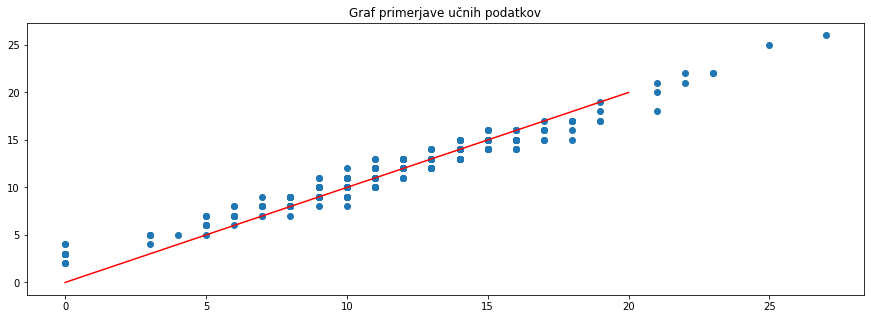

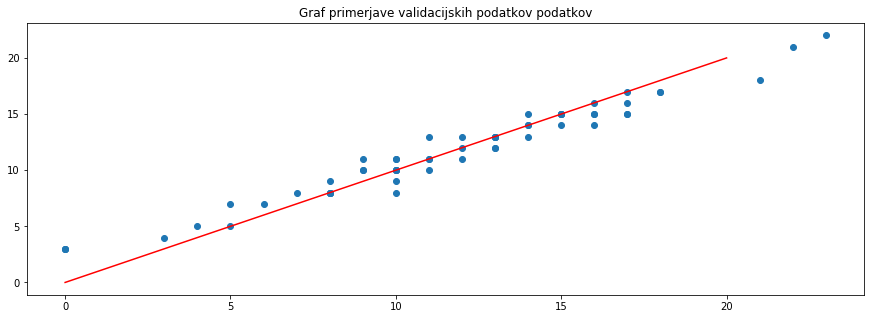

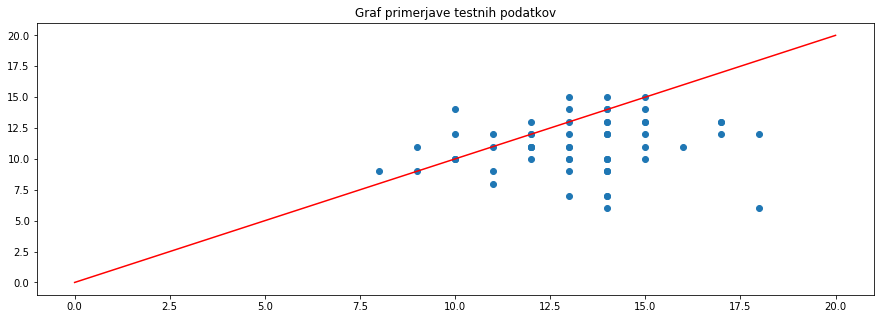

In [ ]:
### BEGIN SOLUTION

### END SOLUTION

### Analiza rezultatov

Ali so rezultati na učni, validacijski in testni množici primerljivi? Kaj je razlog za (ne)primerljivost? Odgovore podkrepite z grafičnimi oz. številskimi argumenti.

/home/zbizjak/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


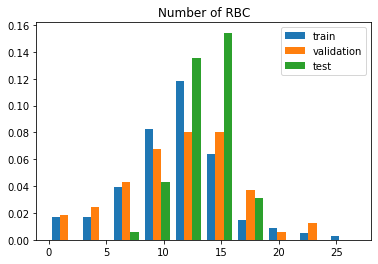

In [ ]:
### BEGIN SOLUTION

### END SOLUTION